#### In this exercise we walk you through the task of classifying flowers in images. 

We will use a pre-trained VGG model for representing flower-images, and feed the output into a simple linear SVM (no image pre-processing other than chanel mean normalization).

The <b>task</b> you will accomplish in this exercise was the content of a (very successful) PhD just under 10 years ago, demonstrating the huge leap in technical ability, as applied to the field of computer vision, brought about by CNNs. 

This exercise is highly demonstrative of the common practice of using deep learning for image classification problems with a pre-trained model and a much smaller specific labeled dataset. To get better results one might add some pre-processing, or a fancier classifier, but the power of CNNs is demonstrated by the out-of-the-box-ness of the solution, already acheiving over 80% accuracy.


---

#### Materials: 
1. dataset: http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html
(download 1 & 4; 336M)
    Place the files under DATA_DIR
2. VGG pretrained model for Keras (will be auto-downloaded upon first usage; ~60M)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.misc import imread, imresize

from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC

import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD

import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = '/tmp/data' if not 'win' in sys.platform else "c:\\tmp\\data"
IMAGE_DIR = os.path.join(DATA_DIR, "flowers")
DEFAULT_VGG_IMAGE_SIZE = (224, 224)
NUM_IMAGES = 8141
NUM_CLASSES = 102

In [3]:
def load_single_img(file_name, resize_to=DEFAULT_VGG_IMAGE_SIZE):
    img = imread(os.path.join(IMAGE_DIR, "jpg", file_name))
    img = imresize(img, resize_to)
    return img

## 1. Visualization 
Using the load_single_img method above, plot a 10X10 grid of random flower images from the dataset. Do you recongnize any of them? 

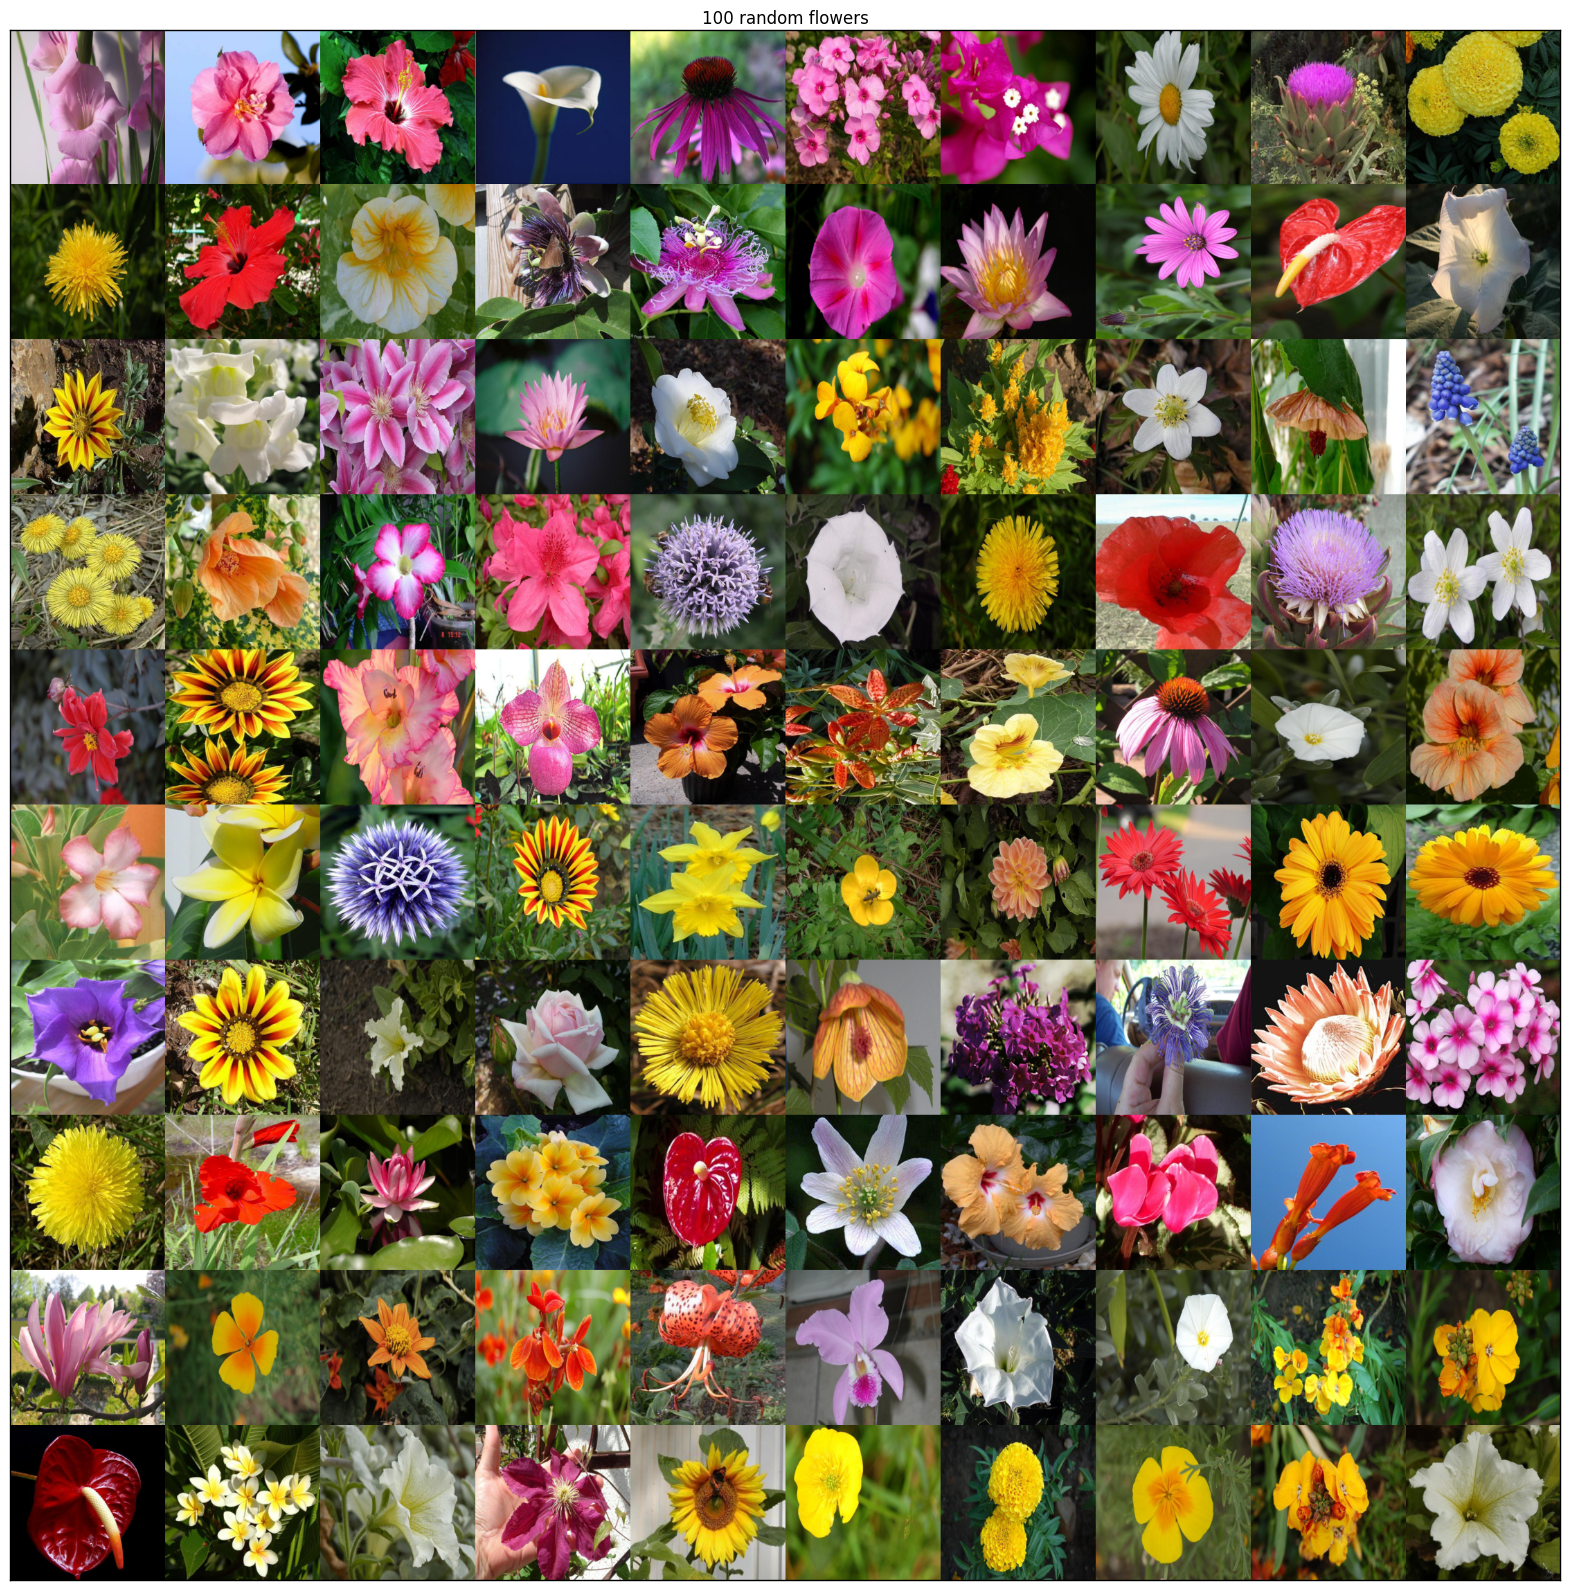

In [4]:
img = np.vstack([np.hstack([load_single_img("image_{:05}.jpg".format(i+1))
                            for i in np.random.randint(1, NUM_IMAGES, 10)])
                 for i in range(10)])
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.title("100 random flowers")

## 2. In this section we select a subset of the flower classes, and build a classifier for them using the pre-trained Keras VGG model and a linear SVM.

### 2.1 Complete the VGGRep class defined below. 
When you are done, the .represent(images) method should return a numpy.Array with the VGG representation of `images`.

### 2.2 Cross validated classifier results
1. Select a small number (3-5 for instance) of classes out of the 102 flower types in the dataset. 
2. Run the VGG representation of the selected images. 
3. Using a crosss-validation procedure, determine the accuracy of a linear SVM applied to this representation.
    
    hint: use cross_val_score, and LinearSVC (imported above)

In [5]:
def load_images_labels(use_classes=None, resize_to=DEFAULT_VGG_IMAGE_SIZE):

    # Load the .mat label file
    labels = loadmat(os.path.join(IMAGE_DIR, "imagelabels.mat"))["labels"].ravel()

    # If use_classes is None, it becomes all 102 available classes
    use_classes = use_classes or list(range(NUM_CLASSES))

    # Compile a list of flower-image files we are going to use, and the associated label in the format [(file, label),
    file_name_label = [("image_{:05}.jpg".format(i+1), labels[i])
                       for i in range(NUM_IMAGES) if labels[i] in use_classes]

    # Load images and labels
    images = [load_single_img(file_name, resize_to=resize_to) for file_name, _ in file_name_label]
    images = np.array(images)
    labels = [l for _, l in file_name_label]

    return images, labels

In [6]:
class VGGRep(object):
    def load(self):
        m = VGG16(include_top=False, weights='imagenet', pooling='avg')
        m.compile(SGD(), 'categorical_crossentropy')
        m.summary()
        self._m = m
        return self

    @staticmethod
    def pre_process(image):
        # Subtract the TRAINING-DATA mean -- not completely necessary but helps. 
        image[:, :, 0] -= 103.939
        image[:, :, 1] -= 116.779
        image[:, :, 2] -= 123.680
        return image

    def represent_single_image(self, image):
        image = self.pre_process(image)
        image = np.expand_dims(image, axis=0)
        pred = self._m.predict(image)
        return pred[0]

    def represent(self, images):
        assert images.shape[-1] == 3  # Use shape: (None, 224, 224, 3)
        images = images.astype(np.float32)
        return np.array([self.represent_single_image(img) for img in images])

In [7]:
# The 4-class version
CLASSES_TO_USE = (77, 78, 79, 80)
images, labels = load_images_labels(use_classes=CLASSES_TO_USE, 
                                    resize_to=DEFAULT_VGG_IMAGE_SIZE)
print(images.shape)
vgg_representation = VGGRep().load().represent(images)
pcorr = cross_val_score(LinearSVC(), vgg_representation, labels).mean() * 100.
print("Overall percent correct: {:.4f}%".format(pcorr))

(534, 224, 224, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0 

## 3. In this section we classify all 102 flower calsses
Since running the VGG network to represent all 8141 images in the dataset may take too long, we have prepared a .csv file (vgg_rep.csv) containing the representation of the entire dataset: 
- The index column is the label (class number)
- The header contains the feature number (0-511 -- for the 512 features in the VGG representation we are using)

### 3.1 Classify the entire dataset
Repeat the procedure from section 2.2(3) and determine how well the linear SVM applied to the VGG representation is able to classify the entire 102 classes of flower images.

### 3.2 Classift arbitrary flowers
Now train a single LinearSVM model on all the data. Download a few images from the internet (belonging to classes in the dataset). After resizing them to the appropreate dimensions (DEFAULT_VGG_IMAGE_SIZE), does the model label them correctly?


In [8]:
# The 102-class version 
vgg_rep_all = pd.read_csv(os.path.join(IMAGE_DIR, "vgg_rep.csv"), index_col=0, header=0)
print(vgg_rep_all.values.shape)

X = vgg_rep_all.values
y = vgg_rep_all.index
pcorr = cross_val_score(LinearSVC(), X, y).mean() * 100.
print("Overall percent correct: {:.4f}%".format(pcorr))

(8141, 512)
Overall percent correct: 82.2987%
